# **Jupyter Notebook: DistilBERT CPU 计算分析**

## **Block 1: 加载模型**
本 block 负责：
- **加载 `DistilBERT` 预训练模型**
- **加载 `DistilBERT` Tokenizer**
- **打印模型基本信息（参数量、层数、隐藏大小等）**

In [146]:
### Block 1: 加载模型 ###
import torch
import time
from transformers import DistilBertTokenizer, DistilBertModel

# 打印 PyTorch 版本
print(f"Using PyTorch version: {torch.__version__}")

# 加载预训练模型和 tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# 确保模型在 CPU 上运行
device = torch.device("cpu")
model.to(device)

# 读取模型配置信息
config_dict = model.config.to_dict()

print("\n===== DistilBERT Model Info =====")
print(f"Number of Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Number of Transformer Layers: {config_dict['n_layers']}")
print(f"Hidden Size: {config_dict['dim']}")
print(f"FFN Hidden Size (hidden_dim): {config_dict['hidden_dim']}")
print(f"Number of Attention Heads: {config_dict['n_heads']}")

print(f"Embedding Layer dtype: {model.embeddings.word_embeddings.weight.dtype}")  # 
print(f"Transformer Block 0 FFN dtype: {model.transformer.layer[0].ffn.lin1.weight.dtype}")  # 
print(f"Transformer Block 1 Self-Attention dtype: {model.transformer.layer[1].attention.q_lin.weight.dtype}")

Using PyTorch version: 2.5.1

===== DistilBERT Model Info =====
Number of Parameters: 66,362,880
Number of Transformer Layers: 6
Hidden Size: 768
FFN Hidden Size (hidden_dim): 3072
Number of Attention Heads: 12
Embedding Layer dtype: torch.float32
Transformer Block 0 FFN dtype: torch.float32
Transformer Block 1 Self-Attention dtype: torch.float32


## **Block 2: Tokenization**
本 block 负责：
- **将输入文本转换为 Token**
- **打印 Tokenized 结果**
- **查看 `input_ids` 和 `attention_mask`**
  

In [149]:
 ### Block 2: Tokenization ###
# 定义输入文本
text = "I love deep learning. It's very interesting."

# 进行 Tokenization
inputs = tokenizer(text, return_tensors="pt")

# 打印 Tokenized 结果
print("\n===== Tokenization 结果 =====")
print(f"Input Text: {text}")
print(f"Tokenized Tokens: {tokenizer.tokenize(text)}")
print(f"Token IDs: {inputs['input_ids']}")
print(f"Attention Mask: {inputs['attention_mask']}")


===== Tokenization 结果 =====
Input Text: I love deep learning. It's very interesting.
Tokenized Tokens: ['i', 'love', 'deep', 'learning', '.', 'it', "'", 's', 'very', 'interesting', '.']
Token IDs: tensor([[ 101, 1045, 2293, 2784, 4083, 1012, 2009, 1005, 1055, 2200, 5875, 1012,
          102]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## **Block 3: Embedding 计算**
本 block 负责：
- **将 Token ID 转换为 768 维嵌入向量**
- **查看 `Embedding` 输出形状**
- **计算 `Embedding` FLOPs（计算量）**

In [152]:
### Block 3: 计算 Token Embedding ###
# 获取模型的 Embedding 层
embedding_layer = model.embeddings.word_embeddings

# 计算 Token ID 的 Embedding
token_embeddings = embedding_layer(inputs["input_ids"])

# 打印结果
print("\n===== Token Embedding 结果 =====")
print(f"Token IDs Shape: {inputs['input_ids'].shape}")
print(f"Embedding Output Shape: {token_embeddings.shape}")  # (batch_size, seq_len, hidden_dim)

# 计算 FLOPs
seq_length = token_embeddings.shape[1]
hidden_dim = token_embeddings.shape[2]
total_ebd_flops = seq_length * hidden_dim

print(f"Embedding FLOPs: {total_ebd_flops:,} FLOPs")


===== Token Embedding 结果 =====
Token IDs Shape: torch.Size([1, 13])
Embedding Output Shape: torch.Size([1, 13, 768])
Embedding FLOPs: 9,984 FLOPs


## **Block 4: Self-Attention 计算**
本 block 负责：
- **计算 Query (Q), Key (K), Value (V)**
- **计算 `QK^T`（Attention Scores）**
- **计算 `Softmax(QK^T) V`（最终 Attention 结果）**
- **统计 Self-Attention FLOPs**

In [155]:
### Block 4: 计算 Self-Attention ###
import torch.nn.functional as F

# 提取 DistilBERT 的 Transformer 第一层
transformer_layer = model.transformer.layer[0]  # 取第一层 Transformer

# 获取 Self-Attention 权重
W_Q = transformer_layer.attention.q_lin.weight
W_K = transformer_layer.attention.k_lin.weight
W_V = transformer_layer.attention.v_lin.weight

# 计算 Q, K, V
Q = torch.matmul(token_embeddings, W_Q.T)
K = torch.matmul(token_embeddings, W_K.T)
V = torch.matmul(token_embeddings, W_V.T)

# 计算 QK^T / sqrt(d_k)
d_k = Q.shape[-1] ** 0.5
QK_T = torch.matmul(Q, K.transpose(-2, -1)) / d_k

# 计算 Softmax(QK^T)
attention_weights = F.softmax(QK_T, dim=-1)

# 计算 Attention 结果
attention_output = torch.matmul(attention_weights, V)

# 打印结果
print("\n===== Self-Attention 计算结果 =====")
print(f"Attention Output Shape: {attention_output.shape}")

# 计算 Self-Attention FLOPs
flops_qkv = 3 * seq_length * hidden_dim * hidden_dim  # Q, K, V 计算
flops_qk_t = seq_length * hidden_dim * seq_length  # QK^T 计算
flops_softmax = seq_length * seq_length  # Softmax 计算
flops_attn_v = seq_length * seq_length * hidden_dim  # Softmax(QK^T) @ V

total_att_flops = flops_qkv + flops_qk_t + flops_softmax + flops_attn_v

print(f"Self-Attention FLOPs: {total_att_flops / 1e6:.2f} MFLOPs")


===== Self-Attention 计算结果 =====
Attention Output Shape: torch.Size([1, 13, 768])
Self-Attention FLOPs: 23.26 MFLOPs


## **Block 5: Feed Forward Network (FFN) 计算**
本 block 负责：
- **计算 `FFN(x) = ReLU(xW1 + b1) W2 + b2`**
- **查看 `FFN` 输出形状**
- **统计 `FFN` FLOPs（计算量）**

In [158]:
### Block 5: 计算 Feed Forward Network (FFN) ###
# 获取 FFN 权重
W1 = transformer_layer.ffn.lin1.weight
b1 = transformer_layer.ffn.lin1.bias
W2 = transformer_layer.ffn.lin2.weight
b2 = transformer_layer.ffn.lin2.bias

# 计算 FFN(x) = ReLU(xW1 + b1) W2 + b2
ffn_intermediate = torch.matmul(attention_output, W1.T) + b1
ffn_activated = torch.relu(ffn_intermediate)
ffn_output = torch.matmul(ffn_activated, W2.T) + b2

# 打印结果
print("\n===== Feed Forward Network (FFN) 计算结果 =====")
print(f"FFN Output Shape: {ffn_output.shape}")

# 计算 FFN FLOPs
flops_ffn1 = seq_length * hidden_dim * 3072  # FFN 第一层 MatMul
flops_relu = seq_length * 3072  # ReLU 计算
flops_ffn2 = seq_length * 3072 * hidden_dim  # FFN 第二层 MatMul
total_ffn_flops = flops_ffn1 + flops_relu + flops_ffn2

print(f"Feed Forward Network (FFN) FLOPs: {total_ffn_flops / 1e6:.2f} MFLOPs")


===== Feed Forward Network (FFN) 计算结果 =====
FFN Output Shape: torch.Size([1, 13, 768])
Feed Forward Network (FFN) FLOPs: 61.38 MFLOPs


## **Block 6: Layer Normalization & 残差连接**
本 block 负责：
- **计算 `LayerNorm(x + residual)`**
- **查看 `LayerNorm` 输出形状**
- **统计 `LayerNorm` FLOPs（计算量）**

In [161]:
### Block 6: Layer Normalization & 残差连接 ###
# 获取 LayerNorm 层
layernorm1 = transformer_layer.sa_layer_norm
layernorm2 = transformer_layer.output_layer_norm

# 残差连接 + LayerNorm
residual1 = token_embeddings + attention_output
norm1 = layernorm1(residual1)

residual2 = norm1 + ffn_output
norm2 = layernorm2(residual2)

# 打印结果
print("\n===== Layer Normalization & 残差连接 计算结果 =====")
print(f"Final Transformer Output Shape: {norm2.shape}")

# 计算 LayerNorm FLOPs
flops_layernorm1 = 5 * seq_length * hidden_dim  # 第一层 LayerNorm
flops_layernorm2 = 5 * seq_length * hidden_dim  # 第二层 LayerNorm
total_layernorm_flops = flops_layernorm1 + flops_layernorm2

print(f"LayerNorm FLOPs: {total_layernorm_flops / 1e6:.2f} MFLOPs")


===== Layer Normalization & 残差连接 计算结果 =====
Final Transformer Output Shape: torch.Size([1, 13, 768])
LayerNorm FLOPs: 0.10 MFLOPs


## **Block 7: Transformer 层整体计算统计**
本 block 负责：
- **统计 Self-Attention、FFN、LayerNorm 总计算量**
- **计算 Transformer 层 FLOPs**


In [164]:
# 计算 Transformer 层 FLOPs
transformer_layer_flops = total_ebd_flops + total_att_flops + total_ffn_flops + total_layernorm_flops

print("\n===== Transformer 层 FLOPs 计算结果 =====")
print(f"Embedding FLOPs: {total_ebd_flops / 1e6:.2f} MFLOPs")
print(f"Self-Attention FLOPs: {total_att_flops / 1e6:.2f} MFLOPs")
print(f"Feed Forward Network (FFN) FLOPs: {total_ffn_flops / 1e6:.2f} MFLOPs")
print(f"LayerNorm FLOPs: {total_layernorm_flops / 1e6:.2f} MFLOPs")
print(f"Total Transformer Layer FLOPs: {transformer_layer_flops / 1e6:.2f} MFLOPs")

# 计算整个 DistilBERT 的 FLOPs
num_layers = model.config.n_layers  # 获取 Transformer 层数
total_distilbert_flops = transformer_layer_flops * num_layers
print("\n===== 完整模型 总 FLOPs 计算结果 =====")
print(f"Total DistilBERT FLOPs: {total_distilbert_flops / 1e9:.2f} GFLOPs")


===== Transformer 层 FLOPs 计算结果 =====
Embedding FLOPs: 0.01 MFLOPs
Self-Attention FLOPs: 23.26 MFLOPs
Feed Forward Network (FFN) FLOPs: 61.38 MFLOPs
LayerNorm FLOPs: 0.10 MFLOPs
Total Transformer Layer FLOPs: 84.75 MFLOPs

===== 完整模型 总 FLOPs 计算结果 =====
Total DistilBERT FLOPs: 0.51 GFLOPs


## **Block 8: CPU直接运行时间**
- **统计 CPU 运行时间**
- **计算 `DistilBERT` 在 CPU 上的 FLOPs/s**

In [175]:
import time

# 让 CPU 计算 FP16，以匹配 FPGA 计算精度
model.half()

# 重新运行完整的 DistilBERT 推理并测量时间
start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
end_time = time.time()

execution_time = end_time - start_time

print(f"\n===== CPU 运行时间统计 (FP16) =====")
print(f"Total Execution Time: {execution_time:.6f} sec")
print(f"FLOPs per Second (GFLOPs/s): {total_distilbert_flops / execution_time / 1e9:.2f} GFLOPs/s")


===== CPU 运行时间统计 (FP16) =====
Total Execution Time: 0.019826 sec
FLOPs per Second (GFLOPs/s): 25.65 GFLOPs/s


## **Block 9: FPGA 数据传输 (PYNQ)**
本 block 负责：
- **转换 `Q, K` 为 NumPy 格式**
- **准备 FPGA 共享内存（Placeholder）**
- **（Placeholder）模拟数据传输到 FPGA**

In [113]:
import numpy as np

# 确保 Q, K 先 detach，再转换为 NumPy
Q_np = Q.detach().cpu().numpy().astype(np.float32)
K_np = K.detach().cpu().numpy().astype(np.float32)

# Placeholder: 分配 FPGA 共享内存
# fpga_Q = allocate(shape=Q_np.shape, dtype=np.float32)
# fpga_K = allocate(shape=K_np.shape, dtype=np.float32)
# fpga_QK_T = allocate(shape=(Q_np.shape[0], Q_np.shape[1], Q_np.shape[1]), dtype=np.float32)

# Placeholder: 将数据传输到 FPGA
# np.copyto(fpga_Q, Q_np)
# np.copyto(fpga_K, K_np)

print("\n===== FPGA 数据传输 (Placeholder) =====")
print(f"Q Shape: {Q_np.shape}")
print(f"K Shape: {K_np.shape}")
print("数据准备完成，等待 FPGA 计算...")


===== FPGA 数据传输 (Placeholder) =====
Q Shape: (1, 13, 768)
K Shape: (1, 13, 768)
数据准备完成，等待 FPGA 计算...


## **Block 10: FPGA 计算 QK^T**
本 block 负责：
- **（Placeholder）调用 FPGA 计算 `QK^T`**
- **（Placeholder）读取 FPGA 计算结果**
- **记录 FPGA 计算时间**

In [122]:
import time

# Placeholder: 记录 FPGA 运行时间
fpga_start_time = time.time()

# Placeholder: 调用 FPGA 计算
# matmul_accel.call(fpga_Q, fpga_K, fpga_QK_T)

# Placeholder: 读取 FPGA 结果
# fpga_output = np.copy(fpga_QK_T)
# fpga_QK_T_torch = torch.tensor(fpga_output)

fpga_end_time = time.time()
fpga_execution_time = fpga_end_time - fpga_start_time

print("\n===== FPGA 计算 QK^T (Placeholder) =====")
# print(f"FPGA Output Shape: {fpga_QK_T_torch.shape}")
print(f"FPGA Execution Time (Placeholder): {fpga_execution_time:.6f} sec")


===== FPGA 计算 QK^T (Placeholder) =====
FPGA Execution Time (Placeholder): 0.000028 sec


## **Block 11: FPGA 计算性能 vs CPU 性能对比**
本 block 负责：
- **计算 CPU 运行时间**
- **（Placeholder）估算 FPGA 运行时间**
- **计算 **FPGA 加速比（暂定 10x）**


In [125]:
# Placeholder: 假设 FPGA 加速比 = 10x（等 FPGA 代码完成后替换）
assumed_fpga_speedup = 10
fpga_simulated_execution_time = execution_time / assumed_fpga_speedup  # 估算 FPGA 运行时间

print("\n===== FPGA vs CPU 性能对比 (Placeholder) =====")
print(f"CPU Execution Time: {execution_time:.6f} sec")
print(f"FPGA Execution Time (Estimated): {fpga_simulated_execution_time:.6f} sec")
print(f"Estimated Speedup: {assumed_fpga_speedup}x")


===== FPGA vs CPU 性能对比 (Placeholder) =====
CPU Execution Time: 0.051395 sec
FPGA Execution Time (Estimated): 0.005139 sec
Estimated Speedup: 10x


## **Block 11: 可视化 CPU vs FPGA 加速比**
本 block 负责：
- **绘制 CPU vs FPGA 运行时间对比图**
- **展示 `QK^T` 计算在 CPU 和 FPGA 上的性能差异**

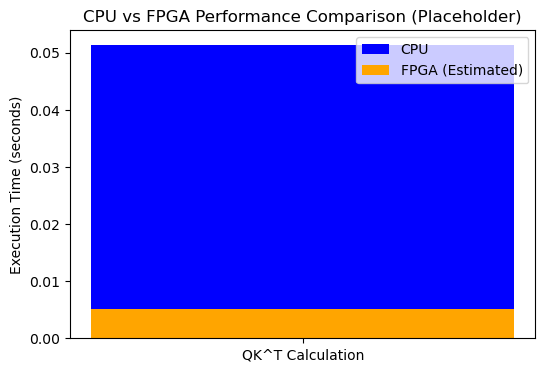

In [128]:
import matplotlib.pyplot as plt

# 真实 CPU 运行时间
cpu_times = [execution_time]
# 估算的 FPGA 运行时间
fpga_times = [fpga_simulated_execution_time]
labels = ["QK^T Calculation"]

# 绘制对比柱状图
plt.figure(figsize=(6, 4))
plt.bar(labels, cpu_times, width=0.4, label="CPU", color="blue")
plt.bar(labels, fpga_times, width=0.4, label="FPGA (Estimated)", color="orange")
plt.ylabel("Execution Time (seconds)")
plt.title("CPU vs FPGA Performance Comparison (Placeholder)")
plt.legend()
plt.show()